In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import os
import math
import cv2
import shutil

import numpy as np
import pandas as pd

import matplotlib.mlab as mlab
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage import data, io, filters, color, morphology, util, feature
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage.filters import sobel
from PIL import Image
import pims
import trackpy as tp

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
mpl.rc('figure',  figsize=(15, 10))
mpl.rc('image', cmap='gray')

# Show Image

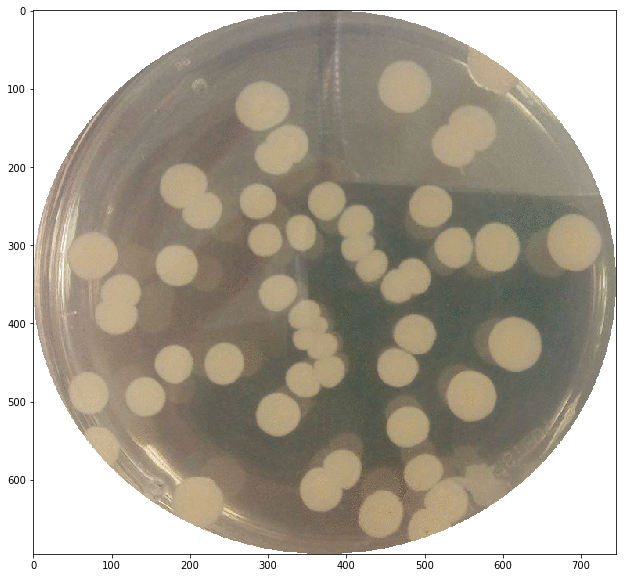

In [34]:
base_image = './data/imageedit_2_7224361676.png'
# base_image = './base_image.png'
img_orig = Image.open(base_image)
plt.imshow(img_orig)

### Crop Image In 4 Quadrants

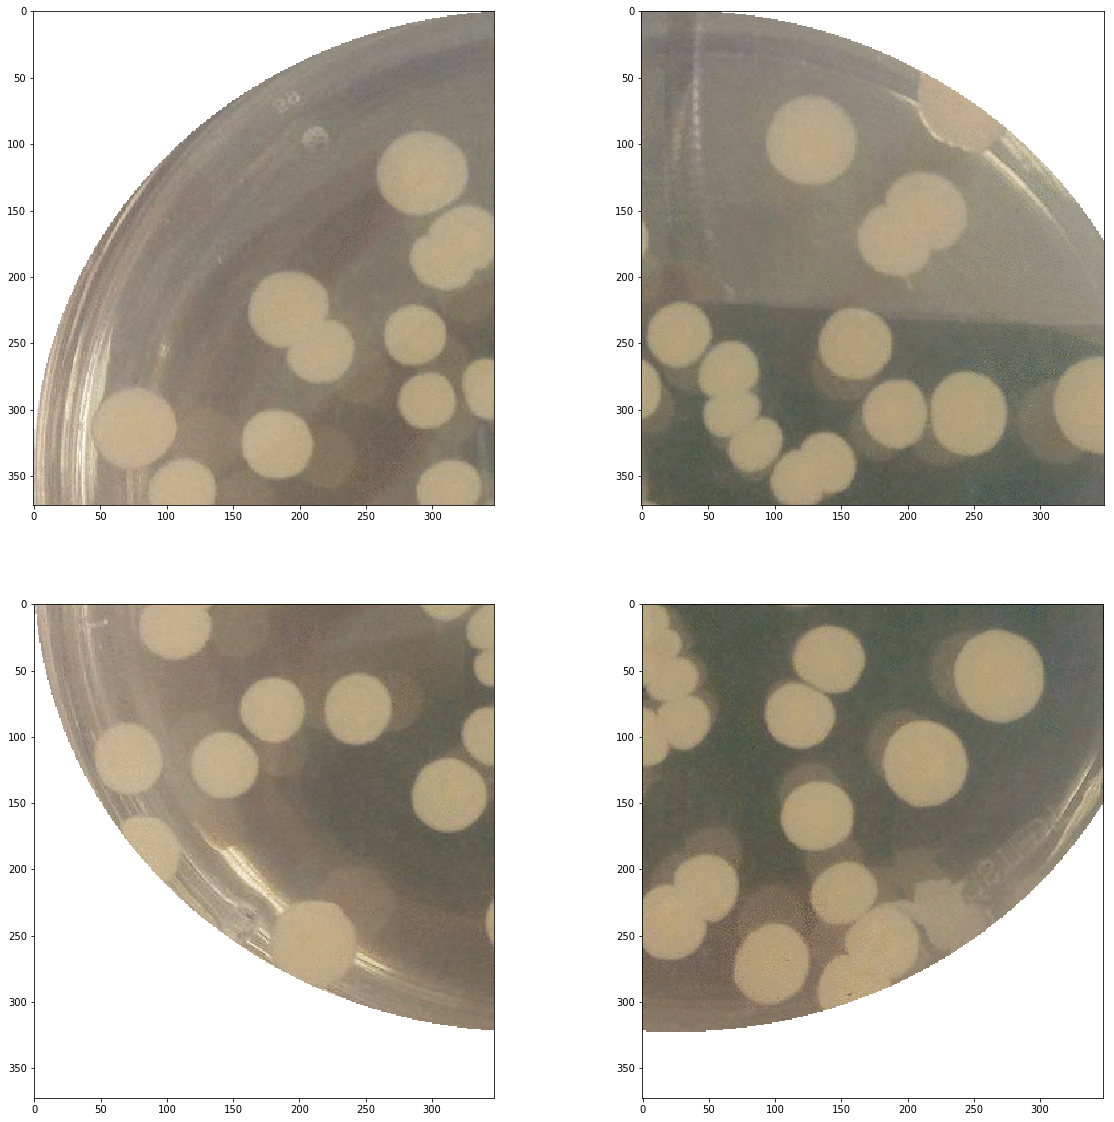

In [35]:
size = img_orig.size
h = img_orig.size[0]
w = img_orig.size[1]

quadrant_crops = [(0, 0, int(w/2), int(h/2)),(int(w/2), 0, w, int(h/2)),(0, int(h/2),int(w/2), h),(int(w/2), int(h/2), w, h)]
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
figs = [(0,0),(0,1),(1,0),(1,1)]
for j in range(len(quadrant_crops)):
    quadrant = img_orig.crop(quadrant_crops[j])
    quadrant.save('Q'+str(j)+'.png')
    ax[figs[j]].imshow(quadrant)

# CODE

In [36]:
def cut_in_quads(f_name):
    
    img_orig = Image.open(f_name)
    size = img_orig.size
    h = img_orig.size[0]
    w = img_orig.size[1]

    quadrant_crops = [(0, 0, int(w/2), int(h/2)),(int(w/2), 0, w, int(h/2)),(0, int(h/2),int(w/2), h),(int(w/2), int(h/2), w, h)]
    for j in range(len(quadrant_crops)):
        quadrant = img_orig.crop(quadrant_crops[j])
        quadrant.save('Q'+str(j)+'.png')
    return None

def cut_in_half(f_name, orientation='vertical'):
    crops = []
    img_orig = Image.open(f_name)
    size = img_orig.size
    h = img_orig.size[0]
    w = img_orig.size[1]
    
    if orientation == 'vertical':
        vertical_crops = [(0, 0, int(w/2), h), (int(w/2), 0, w, h)]
        for j, v in enumerate(vertical_crops):
            half = img_orig.crop(v)
            half.save('HV'+str(j)+'.png')
            
    elif orientation == 'horizontal':
        vertical_crops = [(0, 0, w, int(h/2)), (0, int(h/2), w, h)]
        for j, v in enumerate(vertical_crops):
            half = img_orig.crop(v)
            half.save('HH'+str(j)+'.png')
            
    return None

In [37]:
def rotate_images(base_image,angle=45,n=4):
    img = Image.open(base_image)
    for i in range(n):
        img2 = img.rotate(angle*i)
        img2.save('./seed_images/seed_'+str(i)+'.png')
    return None

In [38]:
def filter_out_colonies(f_name):
    full_frame = pims.ImageSequence(f_name, as_grey=True)[0]
    
    frames = [full_frame]
    
    # quadrants
    for i in range(4):
#         print('Quad Frame: ',i)
        frame = pims.ImageSequence('./Q'+str(i)+'.png', as_grey=True)[0]
        frames.append(frame)
    
    # HV
    for i in range(2):
#         print('HV Frame: ',i)
        frame = pims.ImageSequence('./HV'+str(i)+'.png', as_grey=True)[0]
        frames.append(frame)
    
    # HH
    for i in range(2):
#         print('HH Frame: ',i)
        frame = pims.ImageSequence('./HH'+str(i)+'.png', as_grey=True)[0]
        frames.append(frame)
    
    to = []
    for c in range(9):
#         print('Counting: ', c)
        edges = canny(frames[c]/255.,sigma=1)
        fill_coins = ndi.binary_fill_holes(edges)
        label_objects, nb_labels = ndi.label(fill_coins)
        sizes = np.bincount(label_objects.ravel())
        mask_sizes = sizes > 40
        mask_sizes[0] = 0
        coins_cleaned = mask_sizes[label_objects]
        to.append(coins_cleaned)
    return np.array(to)

In [39]:
def erase_directory_contents(folder='./temp'):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)
    return None

In [40]:
erase_directory_contents('./temp/')
erase_directory_contents('./seed_images/')

### CONFIGURE

In [41]:
rotate_images(base_image=base_image)
file_paths = ['./seed_images/'+ f for f in os.listdir('./seed_images/')]

In [42]:
counts =  []
for file_path in file_paths[:1]:
    print(file_path)
    cut_in_quads(f_name=file_path)
    cut_in_half(f_name=file_path, orientation='horizontal')
    cut_in_half(f_name=file_path, orientation='vertical')
    cou = filter_out_colonies(file_path)
    counts.append(cou)

for c, count in enumerate(counts):
    for i in range(len(count)):
        plt.imsave('./temp/bw_'+str(c)+'_'+str(i)+'.png', arr=counts[c][i])

./seed_images/seed_0.png


In [45]:
mean_diameter_pixels = 41

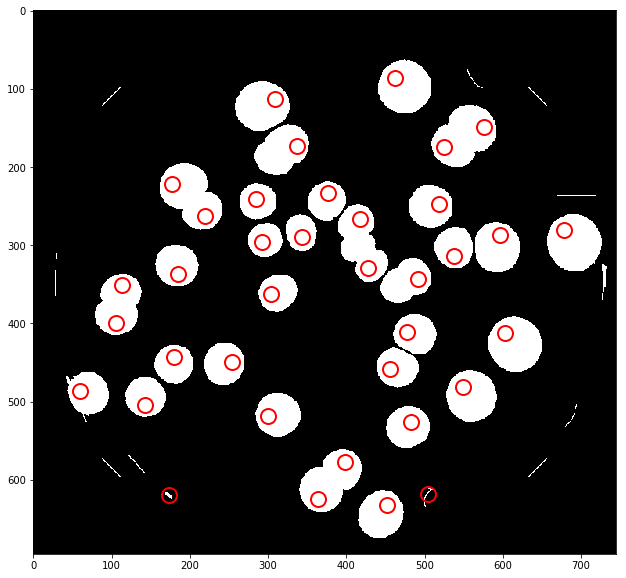

In [46]:
full_frames = pims.ImageSequence('./temp/*.png', as_grey=True)
frame = full_frames[0]
f = tp.locate(frame,mean_diameter_pixels)
f.head(),f.shape
plt.figure()
tp.annotate(f,frame)

### ignore small masses

In [49]:
mass_threshold = 0

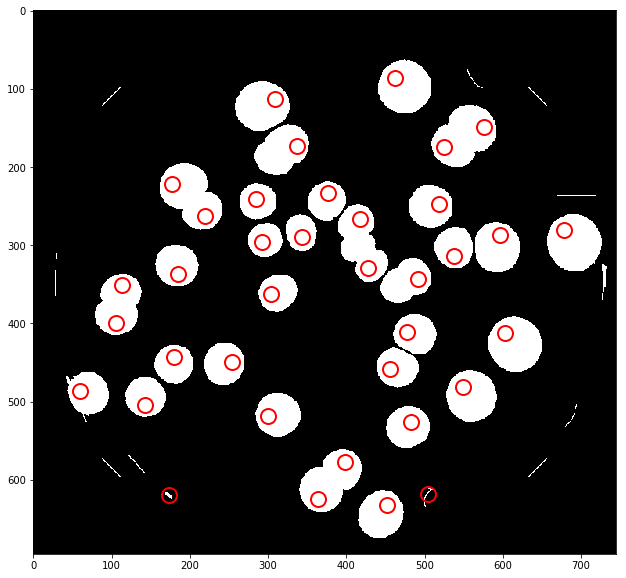

In [50]:
fa = f[f.mass>f.mass.min()*mass_threshold]
plt.figure()
tp.annotate(fa,frame)

In [51]:
erase_directory_contents('./temp/')
erase_directory_contents('./seed_images/')

In [52]:
rotate_images(base_image=base_image)
file_paths = ['./seed_images/'+ f for f in os.listdir('./seed_images/')]

In [53]:
counts =  []
for file_path in file_paths[:]:
    print(file_path)
    cut_in_quads(f_name=file_path)
    cut_in_half(f_name=file_path, orientation='horizontal')
    cut_in_half(f_name=file_path, orientation='vertical')
    cou = filter_out_colonies(file_path)
    counts.append(cou)

colo = []
for c, count in enumerate(counts):
    print('seeds: ',c)
    for i in range(len(count)):
        print('saving: ', i)
        plt.imsave('./temp/bw_'+str(0)+'_'+str(i)+'.png', arr=counts[c][i])
    full_frames = pims.ImageSequence('./temp/*.png', as_grey=True)
    ec = []
    for f, frame in enumerate(full_frames):
        print('reading: ',f)
        f = tp.locate(frame, mean_diameter_pixels)
        # enter mass filter
        ec.append(f.shape[0])
    print('done: ',c)    
    colo.append(ec)

./seed_images/seed_0.png
./seed_images/seed_1.png
./seed_images/seed_2.png
./seed_images/seed_3.png
seeds:  0
saving:  0
saving:  1
saving:  2
saving:  3
saving:  4
saving:  5
saving:  6
saving:  7
saving:  8
reading:  0
reading:  1
reading:  2
reading:  3
reading:  4
reading:  5
reading:  6
reading:  7
reading:  8
done:  0
seeds:  1
saving:  0
saving:  1
saving:  2
saving:  3
saving:  4
saving:  5
saving:  6
saving:  7
saving:  8
reading:  0
reading:  1
reading:  2
reading:  3
reading:  4
reading:  5
reading:  6
reading:  7
reading:  8
done:  1
seeds:  2
saving:  0
saving:  1
saving:  2
saving:  3
saving:  4
saving:  5
saving:  6
saving:  7
saving:  8
reading:  0
reading:  1
reading:  2
reading:  3
reading:  4
reading:  5
reading:  6
reading:  7
reading:  8
done:  2
seeds:  3
saving:  0
saving:  1
saving:  2
saving:  3
saving:  4
saving:  5
saving:  6
saving:  7
saving:  8
reading:  0
reading:  1
reading:  2
reading:  3
reading:  4
reading:  5
reading:  6
reading:  7
reading:  8
done:

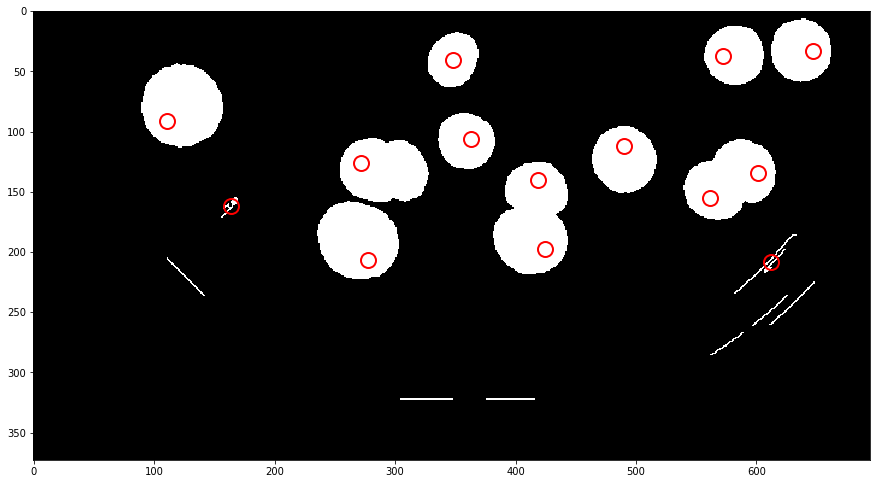

In [54]:
plt.figure()
tp.annotate(f,frame)

In [55]:
final = []
for col in colo:
    final.append(col[:1]+ [sum(col[1:5])] + [sum(col[5:7])] + [sum(col[7:])])

In [56]:
data = np.array(final)

In [57]:
data.mean()

27.1875

In [58]:
data.std()

4.6262667184242634

In [59]:
df = pd.DataFrame(data,columns=['F','Q','HH','HV'])
df.head()

,F,Q,HH,HV
0,37,27,29,32
1,28,21,25,25
2,36,23,27,28
3,29,20,24,24


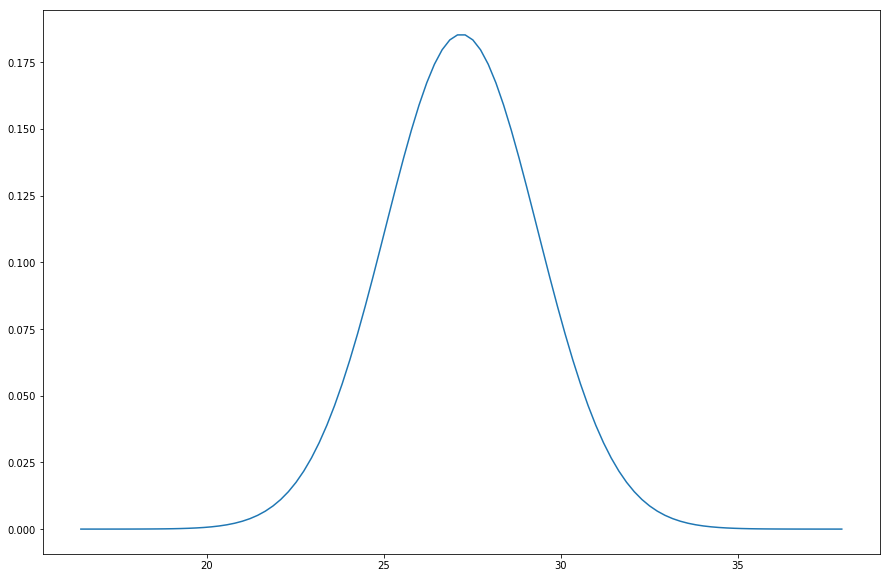

In [60]:
mu = data.mean()
variance = data.std()
sigma = math.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))
plt.show()